# Purpose

This notebook is to do analysis on the distribution of listening events across AllMusic genres by looking at how many top genres is takes to cover a majority of listening events
## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import swifter

## Preparing Data

In [2]:
artistToGenre = pd.read_parquet('../data/LastFM1bKidArtistToAllMusicGenre.gzip.parquet')
artistToGenre.head(5)

,Artist,Genre
0,MEGADETH,HEAVY METAL
1,DREAM THEATER,HEAVY METAL
2,AMON AMARTH,HEAVY METAL
3,ALTER BRIDGE,HEAVY METAL
4,LIMP BIZKIT,HEAVY METAL


### Ranking Genres from most listened to least

In [3]:
genreRanking = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Artist', 'User Id'])
genreRanking = genreRanking.groupby(['Artist']).agg(ArtistCount = ('User Id', 'count')).reset_index()
genreRanking.head(5)

,Artist,ArtistCount
0,! WWW.POLSKIE-MP3.TK ! AFRO KOLEKTYW,1
1,! WWW.POLSKIE-MP3.TK ! AKURAT,21
2,! WWW.POLSKIE-MP3.TK ! ALKATRAZ,43
3,! WWW.POLSKIE-MP3.TK ! BANACH & INDIOS BRAVOS,4
4,! WWW.POLSKIE-MP3.TK ! BRYGADA KRYZYS,11


In [4]:
genreRanking = genreRanking.merge(artistToGenre, on = 'Artist')
genreRanking.drop(columns = ['Artist'], inplace = True)
genreRanking.head(5)

,ArtistCount,Genre
0,571,ROCK
1,571,POP
2,571,ALTERNATIVE
3,571,PUNK
4,571,ELECTRONIC


In [5]:
genreRanking = genreRanking.groupby(['Genre'], observed = True).agg(Count = ('ArtistCount', 'sum')).reset_index()
genreRanking.head(5)

,Genre,Count
0,ROCK,23655957
1,POP,15639176
2,ALTERNATIVE,23240358
3,PUNK,10402730
4,ELECTRONIC,12304269


### User to Artist counts

In [6]:
userToArtistCounts = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Education Level', 'Age', 'Artist'])
userToArtistCounts.drop(columns = ['Partition'], inplace = True)
userToArtistCounts.head(5)

,Education Level,Age,Artist
0,HS,16,I BREAK HORSES
1,HS,16,TAYLOR SWIFT
2,HS,16,HIM
3,HS,16,AMARANTHE
4,HS,16,AMARANTHE


In [7]:
userToArtistCounts = userToArtistCounts.groupby(['Education Level', 'Age', 'Artist'], observed = True).agg(Count = ('Artist', 'count')).reset_index()
userToArtistCounts.head(5)

,Education Level,Age,Artist,Count
0,HS,15,I BREAK HORSES,5
1,HS,15,TAYLOR SWIFT,15038
2,HS,15,HIM,2180
3,HS,15,AMARANTHE,1792
4,HS,15,SERENITY,6


### Top X Genres to Listening Event Counts

In [8]:
calculations = pd.DataFrame({'Genres': itertools.accumulate(map(lambda x: [x], genreRanking['Genre'].to_list()))})
calculations.head(5)

,Genres
0,[ROCK]
1,"[ROCK, POP]"
2,"[ROCK, POP, ALTERNATIVE]"
3,"[ROCK, POP, ALTERNATIVE, PUNK]"
4,"[ROCK, POP, ALTERNATIVE, PUNK, ELECTRONIC]"


In [9]:
def CountListeningEventsIn(genres):
    result = artistToGenre[artistToGenre['Genre'].isin(genres)][['Artist']].drop_duplicates()
    result = userToArtistCounts.merge(result, on = 'Artist')
    result = result.groupby(['Education Level', 'Age'], observed = True).agg(Total = ('Count', 'sum'))
    result = result.rename(columns = {'Total': len(genres)})
    
    return result

data = calculations['Genres'].swifter.allow_dask_on_strings(enable = True).apply(CountListeningEventsIn)
data = pd.concat(data.to_list(), axis = 1)
data

Dask Apply:   0%|          | 0/19 [00:00<?, ?it/s]

1         2         3         4         5   \
Education Level Age                                                     
HS              15    2776222   3357414   3486545   3549651   3738258   
                16    6202368   7454964   7834041   7962357   8371835   
                17   12523540  14963369  15800442  16036672  16918743   
GS              6      178373    212541    227403    238515    249186   
                7       47727     55672     60218     63887     76107   
                8      110588    152810    160895    161325    164259   
                9        8038      9464     10483     10497     15112   
                10     119162    133660    142558    144696    150520   
                11     123284    150693    159362    160041    168699   
MS              12      77101    100330    111554    113938    140680   
                13     352405    430953    455436    460495    485561   
                14    1002469   1246273   1300611   1323239   1403907   

                           6         7         8         9         10  \
Education Level Age                                                     
HS              15    3748248   3800296   3804209   3813375   3867135   
                16    8411158   8539303   8546748   8551265   8732273   
                17   17000456  17223949  17244819  17259709  17596525   
GS              6      251755    253640    253861    254414    260552   
                7       76578     77082     77352     77450     77880   
                8      164648    164962    165080    165268    166400   
                9       15269     15337     15366     15441     15441   
                10     151251    152223    152523    152694    153856   
                11     172408    174839    175042    175242    179943   
MS              12     142654    144163    144507    144567    146861   
                13     488099    492447    493435    493634    509943   
                14    1410926   1422475   1423684   1425205   1467194   

                           11        12        13        14        15  \
Education Level Age                                                     
HS              15    3868338   3872398   3877966   3945292   3946612   
                16    8736170   8745023   8753718   8898007   8903549   
                17   17601071  17626645  17640451  17938836  17957930   
GS              6      261450    263022    263323    266623    266733   
                7       77915     77991     78020     78219     78253   
                8      166407    166636    166723    168132    168285   
                9       15452     15635     15635     15638     15640   
                10     153966    154103    154201    154401    154436   
                11     180078    180750    181205    181725    181761   
MS              12     146867    147443    147466    149659    149706   
                13     510155    510368    510961    519505    519749   
                14    1467444   1468920   1470636   1495322   1495899   

                           16        17        18        19        20  
Education Level Age                                                    
HS              15    3958426   3958678   3959749   3960086   3960127  
                16    8923575   8925039   8928911   8930245   8930683  
                17   18034015  18035973  18043387  18046779  18046996  
GS              6      268875    268930    269422    269596    269597  
                7       80066     80163     80661     80713     80716  
                8      168523    168531    168545    168575    168576  
                9       15703     15715     15720     15722     15722  
                10     156271    156561    156575    156634    156635  
                11     182000    182024    182428    182479    182487  
MS              12     150419    150526    150545    150588    150589  
                13     521041    521084    521437    521504    521514  
                14    

## Graphs 
### by Age

In [10]:
graphData = data.reset_index().drop(columns = 'Education Level').set_index('Age').unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Age']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Age')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Age,Listening Event Count,Total,% of Listening Events
0,1,15,2776222,3960127,0.701044
1,2,15,3357414,3960127,0.847805
2,3,15,3486545,3960127,0.880412
3,4,15,3549651,3960127,0.896348
4,5,15,3738258,3960127,0.943974
...,...,...,...,...,...
235,16,14,1498865,1503468,0.996938
236,17,14,1502225,1503468,0.999173
237,18,14,1503344,1503468,0.999918
238,19,14,1503467,1503468,0.999999


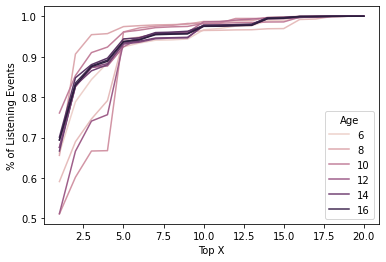

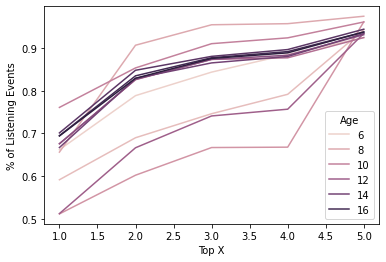

In [11]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Age', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 5], x = 'Top X', hue = 'Age', y = '% of Listening Events');

### by Education Level

In [12]:
graphData = data.reset_index().drop(columns = 'Age').groupby('Education Level').sum().unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Education Level']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Education Level')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Education Level,Listening Event Count,Total,% of Listening Events
0,1,GS,587172,873733,0.672027
1,2,GS,714840,873733,0.818145
2,3,GS,760919,873733,0.870883
3,4,GS,778961,873733,0.891532
4,5,GS,823883,873733,0.942946
5,6,GS,831909,873733,0.952132
6,7,GS,838083,873733,0.959198
7,8,GS,839224,873733,0.960504
8,9,GS,840509,873733,0.961975
9,10,GS,854072,873733,0.977498


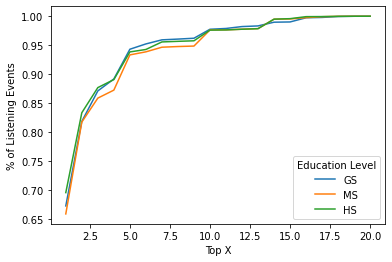

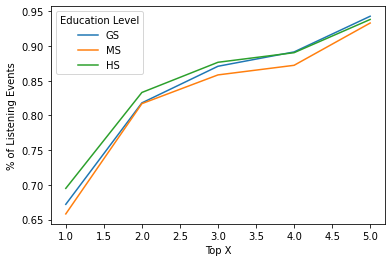

In [13]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Education Level', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 5], x = 'Top X', hue = 'Education Level', y = '% of Listening Events');